# Predicting hospital readmissions using NLP-DL
### By Mostofa Ahsan

Dataset: https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008


In [1]:
import numpy as np
import pandas as pd
import keras
#import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from keras import optimizers

Using TensorFlow backend.


In [2]:
# Import the data

pdata = pd.read_csv('dataset_diabetes/diabetic_data.csv')
pdata.shape

(101766, 50)

In [3]:
pdata.head

<bound method NDFrame.head of         encounter_id  patient_nbr             race  gender      age weight  \
0            2278392      8222157        Caucasian  Female   [0-10)      ?   
1             149190     55629189        Caucasian  Female  [10-20)      ?   
2              64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3             500364     82442376        Caucasian    Male  [30-40)      ?   
4              16680     42519267        Caucasian    Male  [40-50)      ?   
...              ...          ...              ...     ...      ...    ...   
101761     443847548    100162476  AfricanAmerican    Male  [70-80)      ?   
101762     443847782     74694222  AfricanAmerican  Female  [80-90)      ?   
101763     443854148     41088789        Caucasian    Male  [70-80)      ?   
101764     443857166     31693671        Caucasian  Female  [80-90)      ?   
101765     443867222    175429310        Caucasian    Male  [70-80)      ?   

        admission_type_id  discha

Pretty messy and contains data which we may not need, lets try to clean it up a bit

In [4]:
pdata['readmitted'].unique()


array(['NO', '>30', '<30'], dtype=object)

In [5]:
list(pdata.columns)

['encounter_id',
 'patient_nbr',
 'race',
 'gender',
 'age',
 'weight',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'time_in_hospital',
 'payer_code',
 'medical_specialty',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'diag_1',
 'diag_2',
 'diag_3',
 'number_diagnoses',
 'max_glu_serum',
 'A1Cresult',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'examide',
 'citoglipton',
 'insulin',
 'glyburide-metformin',
 'glipizide-metformin',
 'glimepiride-pioglitazone',
 'metformin-rosiglitazone',
 'metformin-pioglitazone',
 'change',
 'diabetesMed',
 'readmitted']

In [6]:
#pdata['diag_3'].unique()

Looking at all fields here there are a few identifying columns:

'patient_nbr' contains a unique identifier of each patient, this is useful so that we can track return visits and see how the patient does over time.

'race', 'gender', & 'age' are all useful to try and notice trends among the patients which are being amitted to the hospital. 'weight' would also be a good metric, but this data set is missing that value for 97% of encounters which is just too many to factor in.

The 'readmitted' field also proves particularly useful as it will be able to tell us if the patient came back in after the appointment

'payer_code' & 'medical_specialty' also have large amounts of missing data (40% and 47% respectively) so these also will not be making the cut

Using only the first visit of each patient also keeps bias from creeping during multiple vists, so we drop repeated vists

In [7]:
pdata = pdata.drop(['weight', 'payer_code', 'medical_specialty'], axis=1)

In [8]:
# Remove duplicates
pdata = pdata.drop_duplicates('patient_nbr')
pdata.shape

# Remove dead & hospice discharge
pdata = pdata.drop(pdata[(pdata.discharge_disposition_id == 11) | 
                         (pdata.discharge_disposition_id == 13) | 
                         (pdata.discharge_disposition_id == 14) | 
                         (pdata.discharge_disposition_id == 19) | 
                         (pdata.discharge_disposition_id == 20) | 
                         (pdata.discharge_disposition_id == 21)].index)
# Now it is considerably smaller, but hopefully will produce better results
pdata.shape

(69973, 47)

Let us take a look at the data to get a better idea of what is contained in it

([<matplotlib.patches.Wedge at 0x7f71e9f6f2b0>,
 [Text(-1.0944145261030003, 0.11071063659263017, 'male'),
  Text(1.0943995898682526, -0.11085818732146416, 'female'),
  Text(0.0001484487693226256, 1.099999989983165, 'unkown')],
 [Text(-0.5969533778743638, 0.060387619959616445, '46.8%'),
  Text(0.5969452308372286, -0.06046810217534408, '53.2%'),
  Text(8.09720559941594e-05, 0.5999999945362717, '0.0%')])

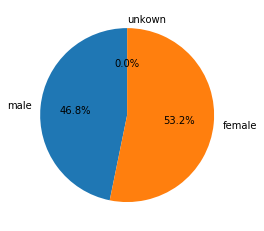

In [9]:
genders = {'male': 0, 'female': 0, 'unkown': 0}
for i in pdata['gender']:
    if i == 'Male':
        genders['male'] = genders['male'] + 1
    elif i == 'Female':
        genders['female'] = genders['female'] + 1
    else:
        genders['unkown'] = genders['unkown'] + 1

# print(genders)
# print(sum(genders.values()))
plt.pie([genders['male'] / sum(genders.values()), 
         genders['female'] / sum(genders.values()),
         genders['unkown'] / sum(genders.values())], 
       labels=genders.keys(), 
       autopct='%1.1f%%', 
       startangle=90)

([<matplotlib.patches.Wedge at 0x7f71e9a98da0>,
 [Text(-0.007556141693172831, 1.0999740472950772, '0-10'),
  Text(-0.041475191906018546, 1.0992178166570805, '10-20'),
  Text(-0.12296286689902669, 1.0931057283556667, '20-30'),
  Text(-0.3073848406138108, 1.0561792271015475, '30-40'),
  Text(-0.7175451146527204, 0.8337439705557184, '40-50'),
  Text(-1.0999996205507658, -0.0009136674294337765, '50-60'),
  Text(-0.33699113182493673, -1.0471088659119205, '60-70'),
  Text(1.02109593852789, -0.4091003352746705, '70-80'),
  Text(0.6713716925278822, 0.8713552951995225, '80-90'),
  Text(0.0868306160762081, 1.0965675738922005, '90-100')],
 [Text(-0.004121531832639726, 0.599985843979133, '0.2%'),
  Text(-0.022622831948737387, 0.5995733545402256, '0.8%'),
  Text(-0.06707065467219636, 0.5962394881939999, '1.6%'),
  Text(-0.16766445851662404, 0.5760977602372077, '3.8%'),
  Text(-0.39138824435602926, 0.4547694384849372, '9.8%'),
  Text(-0.5999997930276904, -0.0004983640524184235, '17.6%'),
  Text(-0.1

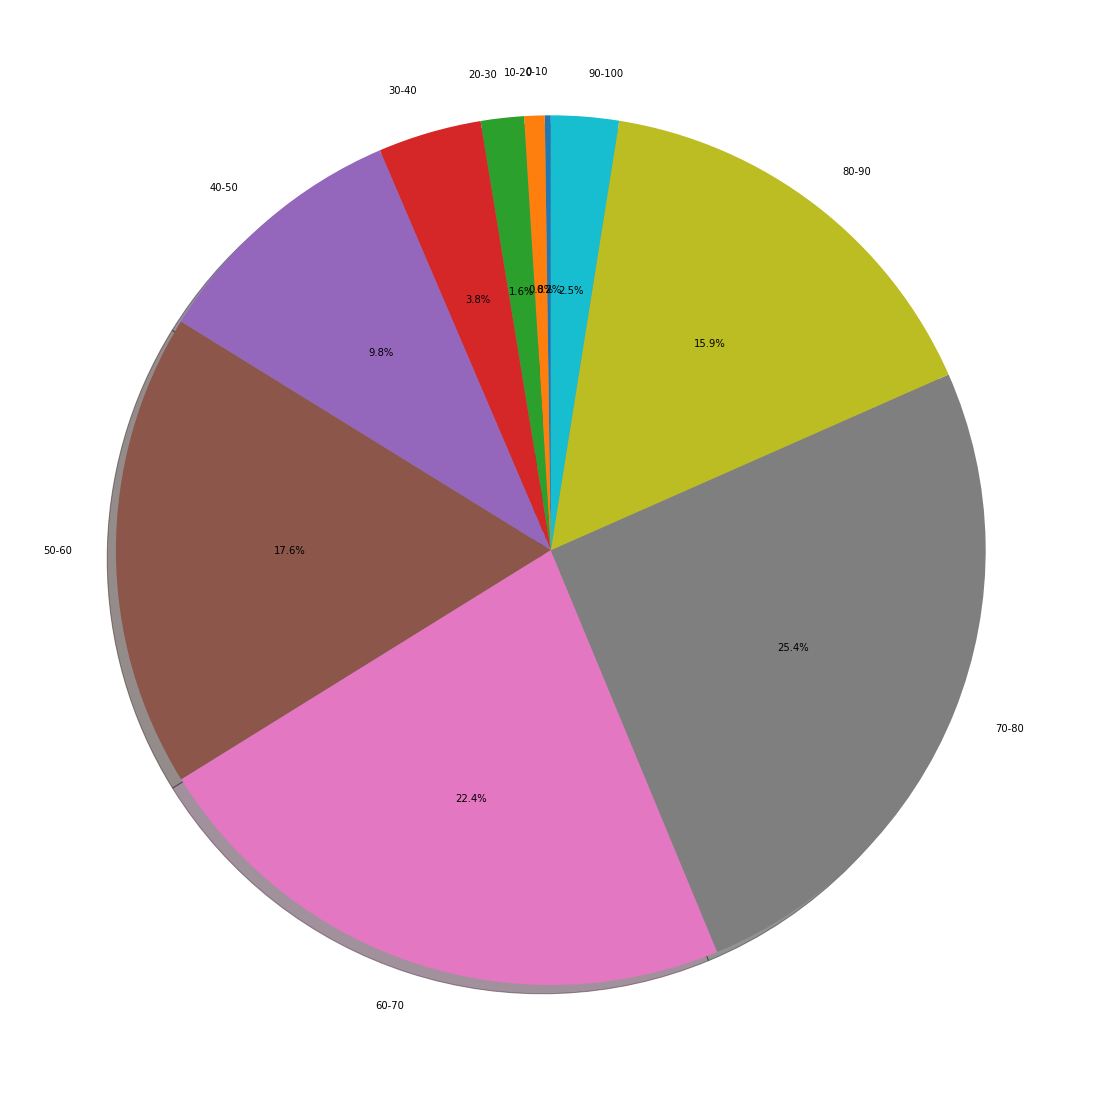

In [10]:
pdata['age'].head(10)
ages = {'0-10': 0, '10-20': 0, '20-30': 0, '30-40': 0, '40-50': 0, '50-60': 0, '60-70': 0, '70-80': 0, '80-90': 0, '90-100': 0}
for i in pdata['age']:
    if i == '[0-10)':
        ages['0-10'] = ages['0-10'] + 1
    elif i == '[10-20)':
        ages['10-20'] = ages['10-20'] + 1
    elif i == '[20-30)':
        ages['20-30'] = ages['20-30'] + 1
    elif i == '[30-40)':
        ages['30-40'] = ages['30-40'] + 1
    elif i == '[40-50)':
        ages['40-50'] = ages['40-50'] + 1
    elif i == '[50-60)':
        ages['50-60'] = ages['50-60'] + 1
    elif i == '[60-70)':
        ages['60-70'] = ages['60-70'] + 1
    elif i == '[70-80)':
        ages['70-80'] = ages['70-80'] + 1
    elif i == '[80-90)':
        ages['80-90'] = ages['80-90'] + 1
    elif i == '[90-100)':
        ages['90-100'] = ages['90-100'] + 1
    else:
        print(i)

#print(ages)

plt.figure(figsize=(20,20))
plt.pie([ages['0-10'] / sum(ages.values()),
        ages['10-20'] / sum(ages.values()),
        ages['20-30'] / sum(ages.values()),
        ages['30-40'] / sum(ages.values()),
        ages['40-50'] / sum(ages.values()),
        ages['50-60'] / sum(ages.values()),
        ages['60-70'] / sum(ages.values()),
        ages['70-80'] / sum(ages.values()),
        ages['80-90'] / sum(ages.values()),
        ages['90-100'] / sum(ages.values())],
        labels=ages.keys(),
        autopct='%1.1f%%',
        shadow=True,
        startangle=90)

{'Caucasian': 52292, 'AfricanAmerican': 12625, 'Asian': 488, 'Hispanic': 1500, 'Other': 1150, 'Missing': 1918}


([<matplotlib.patches.Wedge at 0x7f71e99aff28>,
 [Text(-0.7843462857227573, -0.7712333655080769, 'Caucasian'),
  Text(0.9377950927017122, 0.5749263988586603, 'AfricanAmerican'),
  Text(0.4606472963596317, 0.9989014307510836, 'Asian'),
  Text(0.36977435027133104, 1.0359859699249867, 'Hispanic'),
  Text(0.2441916942748336, 1.0725532231302959, 'Other'),
  Text(0.09460704107596932, 1.095924042887485, 'Missing')],
 [Text(-0.4278252467578676, -0.4206727448225873, '74.7%'),
  Text(0.5115245960191157, 0.3135962175592692, '18.0%'),
  Text(0.25126216165070814, 0.5448553258642274, '0.7%'),
  Text(0.2016951001479987, 0.5650832563227199, '2.1%'),
  Text(0.13319546960445466, 0.5850290307983431, '1.6%'),
  Text(0.051603840586892345, 0.5977767506659009, '2.7%')])

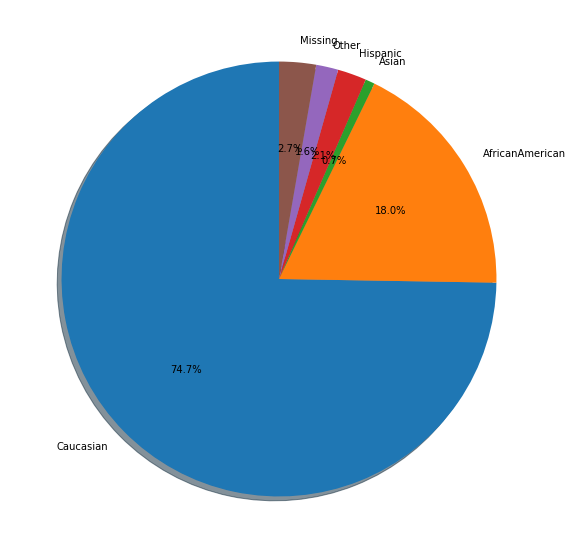

In [11]:
pdata.race.unique()
races = {'Caucasian': 0, 'AfricanAmerican': 0, 'Asian': 0, 'Hispanic': 0, 'Other': 0, 'Missing': 0}
for i in pdata['race']:
    if i == 'Caucasian':
        races['Caucasian'] = races['Caucasian'] + 1
    elif i == 'AfricanAmerican':
        races['AfricanAmerican'] = races['AfricanAmerican'] + 1
    elif i == 'Asian':
        races['Asian'] = races['Asian'] + 1
    elif i == 'Hispanic':
        races['Hispanic'] = races['Hispanic'] + 1
    elif i == 'Other':
        races['Other'] = races['Other'] + 1
    else:
        races['Missing'] = races['Missing'] + 1

print(races)
plt.figure(figsize=(10,10))
plt.pie([races['Caucasian'] / sum(races.values()),
       races['AfricanAmerican'] / sum(races.values()),
       races['Asian'] / sum(races.values()),
       races['Hispanic'] / sum(races.values()),
       races['Other'] / sum(races.values()),
       races['Missing'] / sum(races.values())],
       labels=races.keys(),
       autopct='%1.1f%%',
       shadow=True,
       startangle=90)

{'1': 10470, '2': 12178, '3': 12487, '4': 9423, '5': 6697, '6': 5050, '7': 3902, '8': 2843, '9': 1911, '10': 1506, '11': 1188, '12': 915, '13': 761, '14': 642}


<BarContainer object of 14 artists>

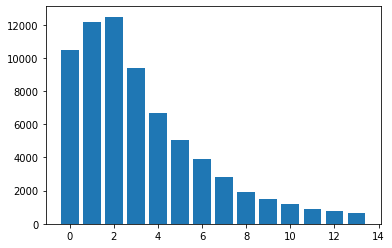

In [12]:
days = {'1': 0, '2': 0, '3': 0, '4': 0, '5': 0, '6': 0, '7': 0, '8': 0, '9': 0, '10': 0, '11': 0, '12': 0, '13': 0, '14': 0}

for i in pdata['time_in_hospital']:
    if i == 1:
        days['1'] = days['1'] + 1
    elif i == 2:
        days['2'] = days['2'] + 1
    elif i == 3:
        days['3'] = days['3'] + 1
    elif i == 4:
        days['4'] = days['4'] + 1
    elif i == 5:
        days['5'] = days['5'] + 1
    elif i == 6:
        days['6'] = days['6'] + 1
    elif i == 7:
        days['7'] = days['7'] + 1
    elif i == 8:
        days['8'] = days['8'] + 1
    elif i == 9:
        days['9'] = days['9'] + 1
    elif i == 10:
        days['10'] = days['10'] + 1
    elif i == 11:
        days['11'] = days['11'] + 1
    elif i == 12:
        days['12'] = days['12'] + 1
    elif i == 13:
        days['13'] = days['13'] + 1
    elif i == 14:
        days['14'] = days['14'] + 1
    else:
        print(i)

print(days)
plt.bar(range(len(days)), list(days.values()), align='center')
#plt.bar(days, max(days.values(), sum(days)))

Time to categorize & split the data

In [13]:
# Create dummy columns for string fields as needed
pdata = pd.get_dummies(pdata, columns=['race', 
                                       'gender', 
                                       'age',
                                       'diag_1',
                                       'diag_2',
                                       'diag_3',
                                       'max_glu_serum',
                                       'A1Cresult',
                                       'metformin',
                                       'repaglinide',
                                       'nateglinide',
                                       'chlorpropamide',
                                       'glimepiride',
                                       'acetohexamide',
                                       'glipizide',
                                       'glyburide',
                                       'tolbutamide',
                                       'pioglitazone',
                                       'rosiglitazone',
                                       'acarbose',
                                       'miglitol',
                                       'troglitazone',
                                       'tolazamide',
                                       'examide',
                                       'citoglipton',
                                       'insulin',
                                       'glyburide-metformin',
                                       'glipizide-metformin',
                                       'glimepiride-pioglitazone',
                                       'metformin-rosiglitazone',
                                       'metformin-pioglitazone',
                                       'change',
                                       'diabetesMed',
                                       'readmitted']) #, drop_first=True)

In [14]:
pdata.shape

(69973, 2291)

In [15]:
# Get the data read to be put into the model

x = pdata.loc[:, :'readmitted_<30'] # Should this be included?
y = pdata.loc[:, 'readmitted_<30':]

x = x.to_numpy()
y = y.to_numpy()

# Split the data into traing and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
type(x_test)

numpy.ndarray

In [54]:
model = Sequential()

# Input layer
model.add(Dense(16, activation='relu', input_shape=(2289,)))

# Hidden layer
model.add(Dropout(0.3, seed=42))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2, seed=42))
model.add(Dense(32, activation='relu'))

# Ouput layer
# model.add(Activation('sigmoid'))
model.add(Dense(3, activation='sigmoid'))

# Compile and add an optimizer & loss
#adam = optimizers.adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ["accuracy"])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 16)                36640     
_________________________________________________________________
dropout_23 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_46 (Dense)             (None, 32)                544       
_________________________________________________________________
dropout_24 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_47 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_48 (Dense)             (None, 3)                 99        
Total params: 38,339
Trainable params: 38,339
Non-trainable params: 0
_________________________________________________________________


In [55]:
# Fit the model
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=256,
                    shuffle=True,
                    validation_data=(x_test, y_test))

Train on 46881 samples, validate on 23092 samples
Epoch 1/10
46881/46881 [==============================] - 1s 25us/step - loss: 5.8083 - acc: 0.6391 - val_loss: 5.3727 - val_acc: 0.6667
Epoch 2/10
46881/46881 [==============================] - 1s 12us/step - loss: 5.5863 - acc: 0.6530 - val_loss: 5.3884 - val_acc: 0.6657
Epoch 3/10
46881/46881 [==============================] - 1s 12us/step - loss: 5.2306 - acc: 0.6750 - val_loss: 4.3410 - val_acc: 0.7292
Epoch 4/10
46881/46881 [==============================] - 1s 12us/step - loss: 4.6868 - acc: 0.7079 - val_loss: 4.9930 - val_acc: 0.6892
Epoch 5/10
46881/46881 [==============================] - 1s 12us/step - loss: 4.7363 - acc: 0.7043 - val_loss: 4.3410 - val_acc: 0.7292
Epoch 6/10
46881/46881 [==============================] - 1s 12us/step - loss: 4.3755 - acc: 0.7246 - val_loss: 4.3410 - val_acc: 0.7292
Epoch 7/10
46881/46881 [==============================] - 1s 12us/step - loss: 4.3838 - acc: 0.7238 - val_loss: 4.3410 - val_acc

In [56]:
# Plot the results for training and validation loss

loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']

#number of epochs
epochs = range(len(loss))

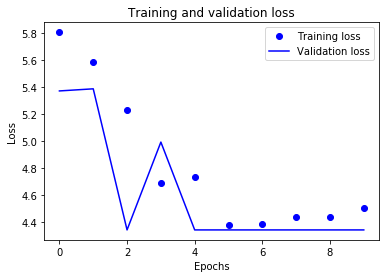

In [57]:
plt.figure()
#training loss
plt.plot(epochs, loss, 'bo', label='Training loss')
#validation loss
plt.plot(epochs, val_loss, 'b', label='Validation loss')
#we add title
plt.title('Training and validation loss')
#we add legends
plt.legend()

# Labels
plt.xlabel('Epochs')
plt.ylabel('Loss')
#finally plot
plt.show()

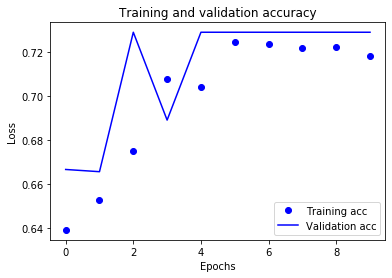

In [58]:
plt.clf() # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')

# Labels
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [59]:
print(np.mean(history.history["val_acc"]))

0.7125887826598746


All with binary cross entropy:
Adam: 0.7221205279953284
NAdam: 0.5977756683253529
SGD: 0.5467818073446449
RMSprop: 0.6341391041829457
Adagrad: 0.5999412170508881